# PyCPT Version 2

This is an example of a PyCPT Version 2 seasonal climate forecasting workflow. This notebook can be adapted to suit your exact needs through modifications of the code. This notebook uses PyCPT v2 utilities to 

1. download data from the IRI Data Library (through the CPT-DL python library) 
2. Run bias-correction using the IRI Climate Predictability Tool (through its companion python library, CPT-CORE) 
3. Plot skills scores and spatial loadings
4. Produce a multi-model ensemble forecast by taking the simple average of the bias-corrected members
5. Plots skill scores, deterministic forecasts, probabilistic forecasts, and exceedance probabilities for this NextGen MME forecast. 

PyCPT Version 2 was primarily designed and implemented by Kyle Hall

#### Imports - This cell imports PyCPTv2 libraries 

In [1]:
import cptdl as dl 
import cptio as cio 
import cptcore as cc 
import cptextras as ce 

import xarray as xr 
import datetime as dt 
from pathlib import Path 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import numpy as np

import cartopy.feature as cartopyFeature
from cartopy.io.shapereader import Reader

import geopandas as gp
import regionmask

make: Nothing to be done for 'build'.


In [2]:
#define case directory
caseDir = "ethiopiaMAM2021analysis"

In [3]:
#prepare country shapefiles for your country. 
#e.g., 'country' for country boundary and 'regions' for county as follows:
country = r'/home/jonyt/Desktop/shapefiles/eth_admbnda_adm0_csa_bofedb_itos_2021.shp'
regions = r'/home/jonyt/Desktop/shapefiles/eth_admbnda_adm1_csa_bofedb_2021.shp'

countryShape = cartopyFeature.ShapelyFeature(Reader(country).geometries(), ccrs.PlateCarree(), edgecolor='black', facecolor='none')
regionShape = cartopyFeature.ShapelyFeature(Reader(regions).geometries(), ccrs.PlateCarree(), edgecolor='black', facecolor='none')

#prepare a mask for your country to mask out regions beyond the country boundary
lats = np.arange(2.5,15.5,0.1)
lons = np.arange(32.5,48.5,0.1)

eth = gp.read_file(country, crs=ccrs.PlateCarree())
#print(type(eth))
mask = regionmask.mask_geopandas(eth, lons, lats)

#### Parameters - This cell defines the parameters of your analysis

In [4]:
#create a 'case directory' wherever you want but in this case on the 'Desktop'
case_directory = Path.home() / "Desktop" / caseDir
case_directory.mkdir(exist_ok=True, parents=True)


MOS = 'PCR' # must be one of 'CCA', 'PCR', or "None" 
predictor_names = ['CanSIPSv2.PRCP','CCSM4.PRCP','GEOSS2S.PRCP','CFSv2.PRCP','SEAS5.PRCP']
predictand_name = 'UCSB.PRCP'

# use dl.observations.keys() to see all options for predictand 
# and dl.hindcasts.keys() to see all options for predictors
# make sure your first_year & final_year are compatible with 
# your selections for your predictors and predictands 

download_args = { 
   # 'fdate':
   #   the initialization date of the model forecasts / hindcasts
   #   this field is defined by a python datetime.datetime object
   #   for example: dt.datetime(2022, 5, 1) # YYYY, MM, DD as integers
   #   The year field is only used for forecasts, otherwise ignored
   #   The day field is only used in subseasonal forecasts, otherwise ignored
   #   The month field is an integer representing a month - ie, May=5
  'fdate': dt.datetime(2021, 2, 1),  
    
   # 'first_year':
   #   the first year of hindcasts you want. **NOT ALL MODELS HAVE ALL YEARS**
   #   double check that your model has hindcast data for all years in [first_year, final_year]
   #   This field is defined by a python integer representing a year, ie: 1993
  'first_year': 1982, 
    
   # 'final_year':
   #   the final year of hindcasts you want. **NOT ALL MODELS HAVE ALL YEARS**
   #   double check that your model has hindcast data for all years in [first_year, final_year]
   #   This field is defined by a python integer representing a year, ie: 2016
  'final_year': 2016, 
    
   # 'predictor_extent':
   #   The geographic bounding box of the climate model data you want to download
   #   This field is defined by a python dictionary with the keys "north", "south",
   #   "east", and "west", each of which maps to a python integer representing the 
   #   edge of a bounding box. i.e., "north" will be the northernmost boundary,
   #   "south" the southernmost boundary. Example: {"north": 90, "south": 90, "east": 0, "west": 180}
  'predictor_extent': {
    'east': 48.5,
    'west': 32.5, 
    'north': 15.5, 
    'south': 2.5
  }, 
    
   # 'predictand_extent':
   #   The geographic bounding box of the observation data you want to download
   #   This field is defined by a python dictionary with the keys "north", "south",
   #   "east", and "west", each of which maps to a python integer representing the 
   #   edge of a bounding box. i.e., "north" will be the northernmost boundary,
   #   "south" the southernmost boundary. Example: {"north": 90, "south": 90, "east": 0, "west": 180}
  'predictand_extent': {
    'east': 48.5,
    'west': 32.5, 
    'north': 15.5, 
    'south': 2.5
  }, 
    
   # 'lead_low': 
   #   the number of months from the first of the initialization month to the center of 
   #   the first month included in the target period. Always an integer + 0.5. 
   #   this field is defined by a python floating point number 
   #   for example  a lead-1 forecast would use lead_low=1.5, if you want init=may, target=Jun-..
  'lead_low': 1.5,
    
   # 'lead_high': 
   #   the number of months from the first of the initialization month to the center of 
   #   the last month included in the target period. Always an integer + 0.5. 
   #   this field is defined by a python floating point number 
   #   for example  a forecast initialized in may, whose target period ended in Aug, 
   #   would use lead_high=3.5
  'lead_high': 3.5, 
    
   # 'target': 
   #   Mmm-Mmm indicating the months included in the target period of the forecast. 
   #   this field is defined by a python string, with two three-letter month name abbreviations 
   #   whose first letters are capitalized, and all other letters are lowercase
   #   and who are separated by a dash character. 
   #   for example, if you wanted a JJA target period, you would use 'Jun-Aug'
  'target': 'Mar-May',
    
   # 'filetype':
   #   the filetype to be downloaded. for now, it saves a lot of headache just to set this equal
   #   to 'cptv10.tsv' which is a boutique plain-text CPT filetype based on .tsv + metadata
  'filetype': 'cptv10.tsv'
}

cpt_args = { 
    'transform_predictand': 'Empirical',  # transformation to apply to the predictand dataset - None, 'Empirical', 'Gamma'
    'tailoring': None,  # tailoring None, Anomaly, StdAnomaly, or SPI (SPI only available on Gamma)
    'cca_modes': (1,3), # minimum and maximum of allowed CCA modes 
    'x_eof_modes': (1,6), # minimum and maximum of allowed X Principal Componenets 
    'y_eof_modes': (1,6), # minimum and maximum of allowed Y Principal Components 
    'validation': 'crossvalidation', # the type of validation to use - crossvalidation, retroactive, or doublecrossvalidation
    'drymask': False, #whether or not to use a drymask of -999
    'scree': True, # whether or not to save % explained variance for eof modes
    'crossvalidation_window': 5,  # number of samples to leave out in each cross-validation step 
    'synchronous_predictors': True, # whether or not we are using 'synchronous predictors'
}

force_download = False

In [5]:
#extracting domain boundaries and create house keeping directories
domain = download_args['predictor_extent']
e,w,n,s = domain.values()

domainFolder = str(w)+"W-" + str(e)+"E" +'_to_'+ str(s)+"S-" + str(n)+"N"

domainDir = Path.home() / "Desktop" / caseDir / domainFolder
domainDir.mkdir(exist_ok=True, parents=True)

dataDir = Path.home() / "Desktop" / caseDir / domainFolder / "data"
dataDir.mkdir(exist_ok=True, parents=True)

figDir = Path.home() / "Desktop" / caseDir / domainFolder / "figures"
figDir.mkdir(exist_ok=True, parents=True)

outputDir = Path.home() / "Desktop" / caseDir / domainFolder / "output"
outputDir.mkdir(exist_ok=True, parents=True)

#print(dataDir)

In [6]:
# Uncomment the following line & change the config filepath to save this configuration: 
config_file = ce.save_configuration(caseDir+'.config', download_args, cpt_args, MOS, predictor_names, predictand_name )

# Uncomment the following line & change the config filepath to load an existing configuration: 
MOS, download_args, cpt_args, predictor_names, predictand_name = ce.load_configuration(caseDir+'.config')

In [8]:
#check out data availability
#dl.hindcasts.keys(), dl.observations.keys(), and/or dl.forecasts.keys() 
print([i for i in list(dl.hindcasts.keys()) if "PRCP" in i])

['CanCM4i.PRCP', 'CanSIPSv2.PRCP', 'GEMNEMO.PRCP', 'CanSIPSIC3.PRCP', 'GEM5NEMO.PRCP', 'CCSM4.PRCP', 'CanCM3.PRCP', 'CanCM4.PRCP', 'AER04.PRCP', 'FLORB01.PRCP', 'FLORA06.PRCP', 'SPEAR.PRCP', 'GEOSS2S.PRCP', 'CFSv2.PRCP', 'SPSv3p5.PRCP', 'SPSv3p0.PRCP', 'GCFS2p0.PRCP', 'GCFS2p1.PRCP', 'SEAS5.PRCP', 'CPS2.PRCP', 'METEOFRANCE7.PRCP', 'METEOFRANCE8.PRCP', 'GLOSEA5.PRCP', 'GLOSEA6.PRCP']


#### Download Observations

In [9]:
if not Path(dataDir / '{}.nc'.format(predictand_name)).is_file() or force_download:
    Y = dl.download(dl.observations[predictand_name], dataDir / (predictand_name +'.tsv'), **download_args, verbose=True, use_dlauth=False)
    Y = getattr(Y, [i for i in Y.data_vars][0])
    Y.to_netcdf(dataDir / '{}.nc'.format(predictand_name))
else:
    Y = xr.open_dataset(dataDir / '{}.nc'.format(predictand_name))
    Y = getattr(Y, [i for i in Y.data_vars][0])

#### Download Hindcast Data

In [10]:
# download training data 
hindcast_data = []
for model in predictor_names: 
    if not Path(dataDir / (model + '.nc')).is_file() or force_download:
        X = dl.download(dl.hindcasts[model],dataDir / ( model+'.tsv'), **download_args, verbose=True, use_dlauth=False)
        X = getattr(X, [i for i in X.data_vars][0])
        X.name = Y.name
        X.to_netcdf(dataDir / '{}.nc'.format(model))
    else:
        X = xr.open_dataset(dataDir / (model + '.nc'))
        X = getattr(X, [i for i in X.data_vars][0])
        X.name = Y.name
    hindcast_data.append(X)

#### Download Forecast Data

In [11]:
# download forecast data 
forecast_data = []
for model in predictor_names: 
    if not Path(dataDir / (model + '_f.nc')).is_file() or force_download:
        F = dl.download(dl.forecasts[model], dataDir / (model+'_f.tsv'), **download_args, verbose=True, use_dlauth=False)
        F = getattr(F, [i for i in F.data_vars][0])
        F.name = Y.name
        F.to_netcdf(dataDir / (model + '_f.nc'))
    else:
        F = xr.open_dataset(dataDir / (model + '_f.nc'))
        F = getattr(F, [i for i in F.data_vars][0])
        F.name = Y.name
    forecast_data.append(F)

#### Perform Analysis 

In [12]:
hcsts, fcsts, skill, pxs, pys = [], [], [], [], []

for i, model_hcst in enumerate(hindcast_data):
    
    
    if str(MOS).upper() == 'CCA':
        
        # fit CCA model between X & Y and produce real-time forecasts for F 
        cca_h, cca_rtf, cca_s, cca_px, cca_py = cc.canonical_correlation_analysis(model_hcst, Y, F=forecast_data[i], **cpt_args)
        #cca_h, cca_rtf, cca_s, cca_px, cca_py = cc.canonical_correlation_analysis(model_hcst, Y, F=forecast_data[i], cpt_kwargs={"interactive":True})
        
        # fit CCA model again between X & Y, and produce in-sample probabilistic hindcasts 
        # this is using X in place of F, with the year coordinates changed to n+100 years
        # because CPT does not allow you to make forecasts for in-sample data
        cca_h, cca_f, cca_s, cca_px, cca_py = cc.canonical_correlation_analysis(model_hcst, Y, F=ce.redate(model_hcst), **cpt_args)
        cca_h = xr.merge([cca_h, ce.redate(cca_f.probabilistic, yeardelta=-100), ce.redate(cca_f.prediction_error_variance, yeardelta=-100)])
        
        # use the in-sample probabilistic hindcasts to perform probabilistic forecast verification
        # warning - this produces unrealistically optimistic values 
        cca_pfv = cc.probabilistic_forecast_verification(cca_h.probabilistic, Y, **cpt_args)
        cca_s = xr.merge([cca_s, cca_pfv])

        hcsts.append(cca_h)
        fcsts.append(cca_rtf)
        skill.append(cca_s.where(cca_s > -999, other=np.nan))
        pxs.append(cca_px)
        pys.append(cca_py)
        
    elif str(MOS).upper() == 'PCR':
        
        # fit PCR model between X & Y and produce real-time forecasts for F 
        pcr_h, pcr_rtf, pcr_s, pcr_px = cc.principal_components_regression(model_hcst, Y, F=forecast_data[i], **cpt_args)
        
        # fit PCR model again between X & Y, and produce in-sample probabilistic hindcasts 
        # this is using X in place of F, with the year coordinates changed to n+100 years
        # because CPT does not allow you to make forecasts for in-sample data
        pcr_h, pcr_f, pcr_s, pcr_px = cc.principal_components_regression(model_hcst, Y, F=ce.redate(model_hcst), **cpt_args)
        pcr_h = xr.merge([pcr_h, ce.redate(pcr_f.probabilistic, yeardelta=-100), ce.redate(pcr_f.prediction_error_variance, yeardelta=-100)])
        
        # use the in-sample probabilistic hindcasts to perform probabilistic forecast verification
        # warning - this produces unrealistically optimistic values 
        pcr_pfv = cc.probabilistic_forecast_verification(pcr_h.probabilistic, Y, **cpt_args)
        pcr_s = xr.merge([pcr_s, pcr_pfv])
        hcsts.append(pcr_h)
        fcsts.append(pcr_rtf)
        skill.append(pcr_s.where(pcr_s > -999, other=np.nan))
        pxs.append(pcr_px)
    else:
        # simply compute deterministic skill scores of non-corrected ensemble means 
        nomos_skill = cc.deterministic_skill(model_hcst, Y, **cpt_args)
        skill.append(nomos_skill.where(nomos_skill > -999, other=np.nan))
        
    # choose what data to export here (any of the above results data arrays can be saved to netcdf)
    if str(MOS).upper() == 'CCA':
        cca_h.to_netcdf(outputDir /  (predictor_names[i] + '_crossvalidated_cca_hindcasts.nc'))
        cca_rtf.to_netcdf(outputDir / (predictor_names[i] + '_realtime_cca_forecasts.nc'))
        cca_s.to_netcdf(outputDir / (predictor_names[i] + '_skillscores_cca.nc'))
        cca_px.to_netcdf(outputDir / (predictor_names[i] + '_cca_x_spatial_loadings.nc'))
        cca_py.to_netcdf(outputDir / (predictor_names[i] + '_cca_y_spatial_loadings.nc'))
    elif str(MOS).upper() == 'PCR':
        pcr_h.to_netcdf(outputDir / (predictor_names[i] + '_crossvalidated_pcr_hindcasts.nc'))
        pcr_rtf.to_netcdf(outputDir / (predictor_names[i] + '_realtime_pcr_forecasts.nc'))
        pcr_s.to_netcdf(outputDir / (predictor_names[i] + '_skillscores_pcr.nc'))
        pcr_px.to_netcdf(outputDir / (predictor_names[i] + '_pcr_x_spatial_loadings.nc'))
    else: 
        nomos_skill.to_netcdf(outputDir / (predictor_names[i] + '_nomos_skillscores.nc'))   

#### Plot skill 

PCR


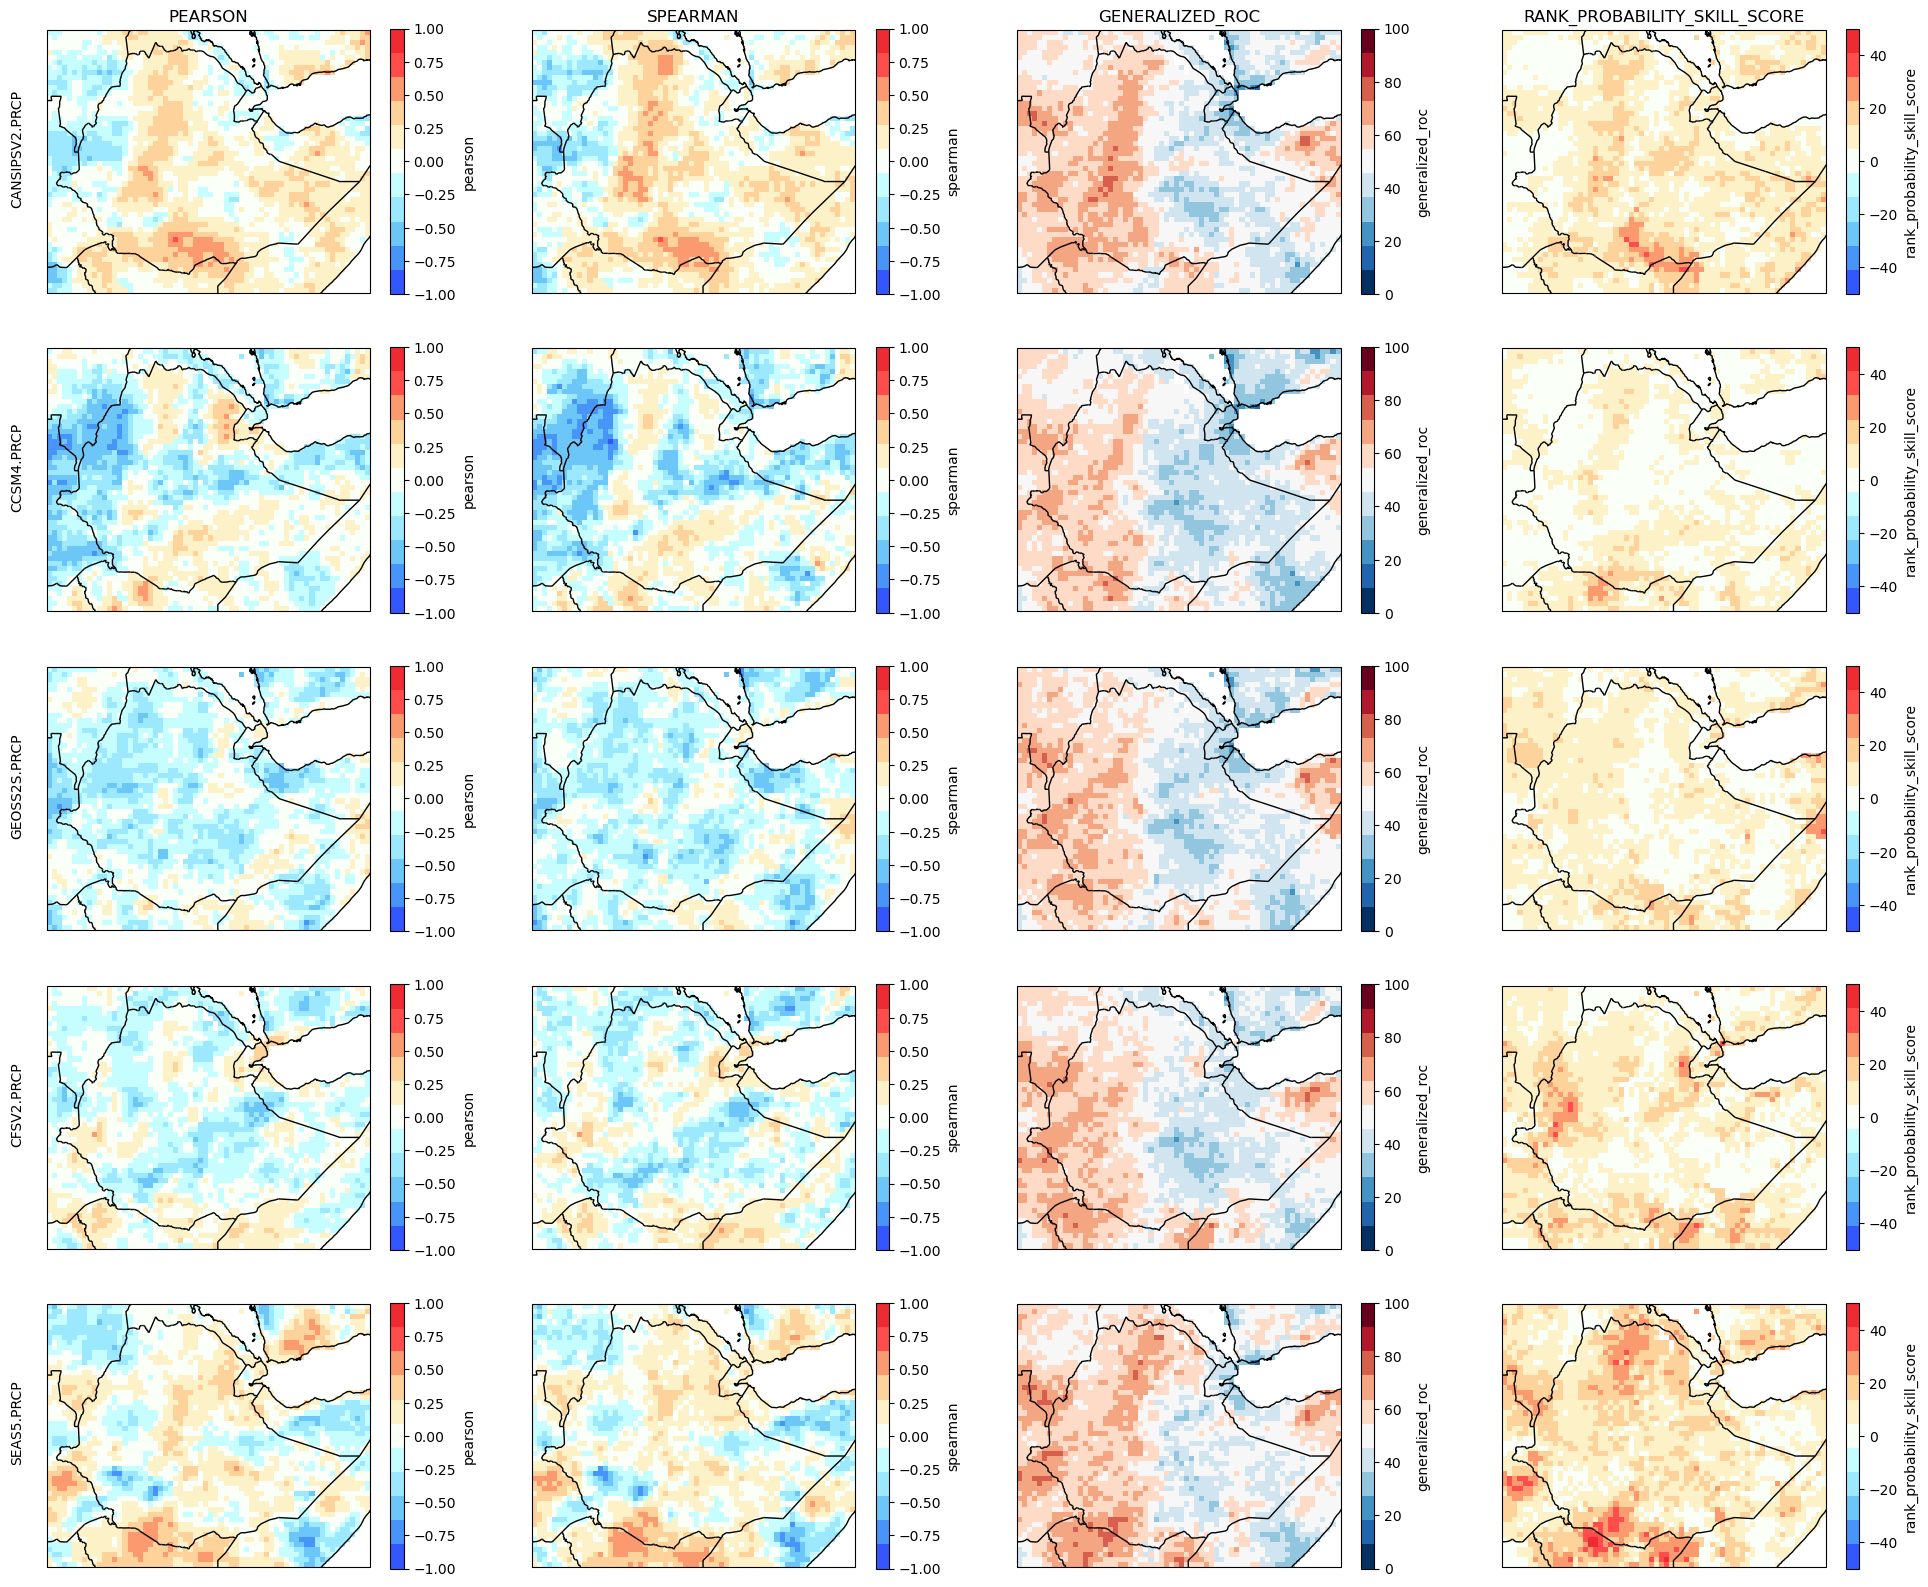

In [13]:
print(MOS)

skill_metrics = ['pearson', 'spearman', 'generalized_roc', 'rank_probability_skill_score']
#cmaps = [plt.get_cmap('cpt.correlation', 11), plt.get_cmap('cpt.correlation', 11), plt.get_cmap('RdBu_r', 11), plt.get_cmap('autumn_r', 11) ]
#limits = [(-1, 1), (-1, 1), (0, 100), (-35, 35)]
cmaps = [plt.get_cmap('cpt.correlation', 11), plt.get_cmap('cpt.correlation', 11), plt.get_cmap('RdBu_r', 11), plt.get_cmap('cpt.correlation', 11) ]
limits = [(-1, 1), (-1, 1), (0, 100), (-50, 50)]

missing_value_flag = -999

fig, ax = plt.subplots(nrows=len(predictor_names), ncols=len(skill_metrics), subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(6*len(skill_metrics), 4*len(predictor_names)))
if len(predictor_names) == 1: 
    ax = [ax]

for i, model in enumerate(predictor_names):
    for j, skill_metric in enumerate(skill_metrics):
        n = getattr(skill[i], skill_metric).where(getattr(skill[i], skill_metric) > missing_value_flag).plot(ax=ax[i][j], cmap=cmaps[j], vmin=limits[j][0], vmax=limits[j][1])
        ax[i][j].coastlines()
        ax[i][j].add_feature(cartopyFeature.BORDERS)
        ax[0][j].set_title(skill_metric.upper())

    ax[i][0].text(-0.07, 0.55, model.upper(), va='bottom', ha='center', rotation='vertical', rotation_mode='anchor', transform=ax[i][0].transAxes)
    
figName = MOS + '_models_skillMatrices.png'
fig.savefig(Path.home() / "Desktop" / caseDir / domainFolder / "figures" / figName, bbox_inches='tight')

#### Plot CCA Modes

In [14]:
nmodes = 3
cmap= plt.get_cmap('cpt.loadings', 11)
vmin=-10
vmax = 10
missing_value_flag = -999

import matplotlib.gridspec as gridspec
if MOS == 'CCA':
    for i, model in enumerate(predictor_names):
        for mode in range(nmodes):
            print(model.upper() + ' - MODE {}'.format(mode+1))
            fig = plt.figure(figsize=(22,5))
            gs0 = gridspec.GridSpec(1, 3, figure=fig)
            gs00 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[0])
            gs01 = gridspec.GridSpecFromSubplotSpec(4, 5, subplot_spec=gs0[1])
            gs02 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[2])
            ts = xr.concat([pxs[i].x_cca_scores.isel(Mode=mode), pys[i].y_cca_scores.isel(Mode=mode)], 'M').assign_coords({'M': ['x', 'y']})
            
            map1_ax = fig.add_subplot(gs00[:,:], projection = ccrs.PlateCarree())
            ts_ax = fig.add_subplot( gs01[1:3,1:])
            map2_ax = fig.add_subplot(gs02[:,:], projection = ccrs.PlateCarree())
            
            pxs[i].x_cca_loadings.isel(Mode=mode).where(pxs[i].x_cca_loadings.isel(Mode=mode) > missing_value_flag).plot(ax=map1_ax, cmap=cmap)
            pys[i].y_cca_loadings.isel(Mode=mode).where(pys[i].y_cca_loadings.isel(Mode=mode) > missing_value_flag).plot(ax=map2_ax, cmap=cmap)

            primitive = ts.plot.line(marker='x', ax=ts_ax, markersize=12, hue='M', add_legend=False)
            ts_ax.grid(axis = 'x', linestyle = '-.')
            ts_ax.legend(handles=primitive, labels = list(ts.coords['M'].values), loc='best')
            ts_ax.spines['top'].set_visible(False)
            ts_ax.spines['right'].set_visible(False)
            ts_ax.spines['bottom'].set_visible(False)
            ts_ax.set_title('CCA Scores (Mode {})'.format(mode+1))
            ts_ax.set_ylabel(None)
            ts_ax.set_xlabel(None)
            
            map1_ax.set_title('X CCA MODE {}'.format(mode+1))
            map2_ax.set_title('Y CCA MODE {}'.format(mode+1))
            
            map1_ax.coastlines()
            map2_ax.coastlines()
            
            map1_ax.add_feature(cartopyFeature.BORDERS)
            map2_ax.add_feature(cartopyFeature.BORDERS)
            plt.show()
            figName = MOS +'_'+ str(model) +'_CCA_mode_' + str(mode + 1) + '.png'
            fig.savefig(Path.home() / "Desktop" / caseDir / domainFolder / "figures" / figName, bbox_inches='tight')
else:
    print('You will need to set MOS=CCA in order to see CCA Modes')

You will need to set MOS=CCA in order to see CCA Modes


#### EOF modes

CANSIPSV2.PRCP - MODE 1


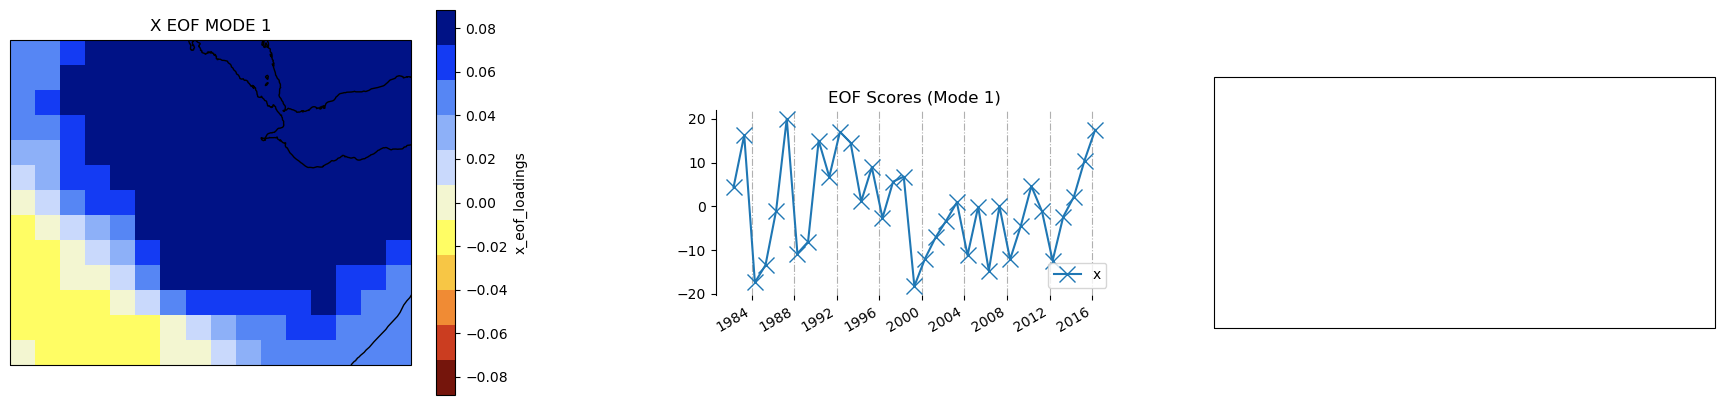

CANSIPSV2.PRCP - MODE 2


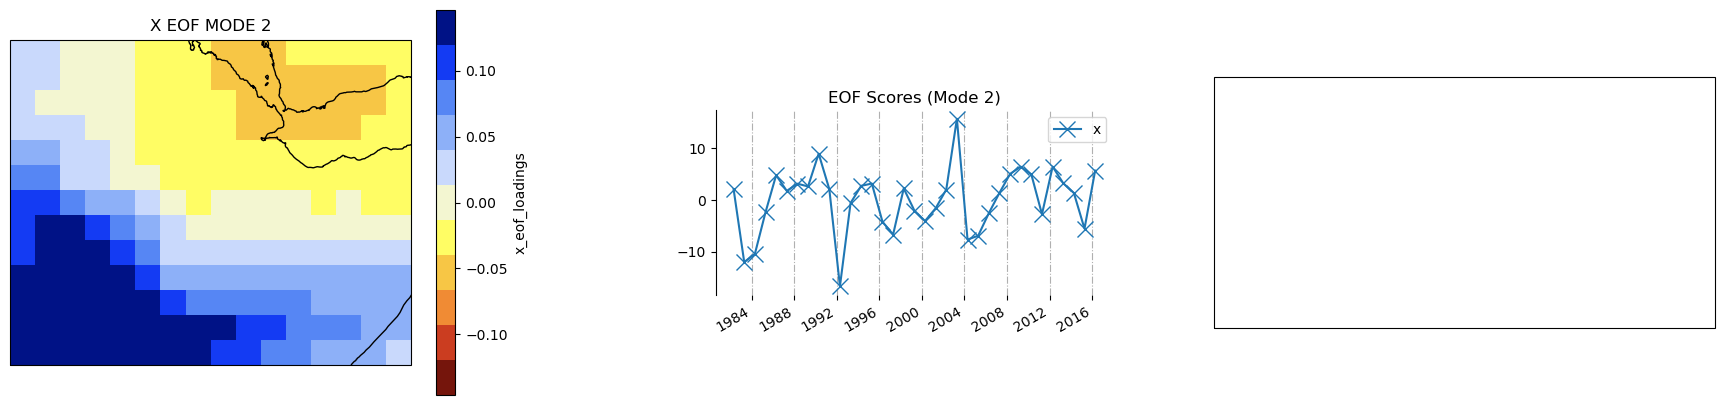

CANSIPSV2.PRCP - MODE 3


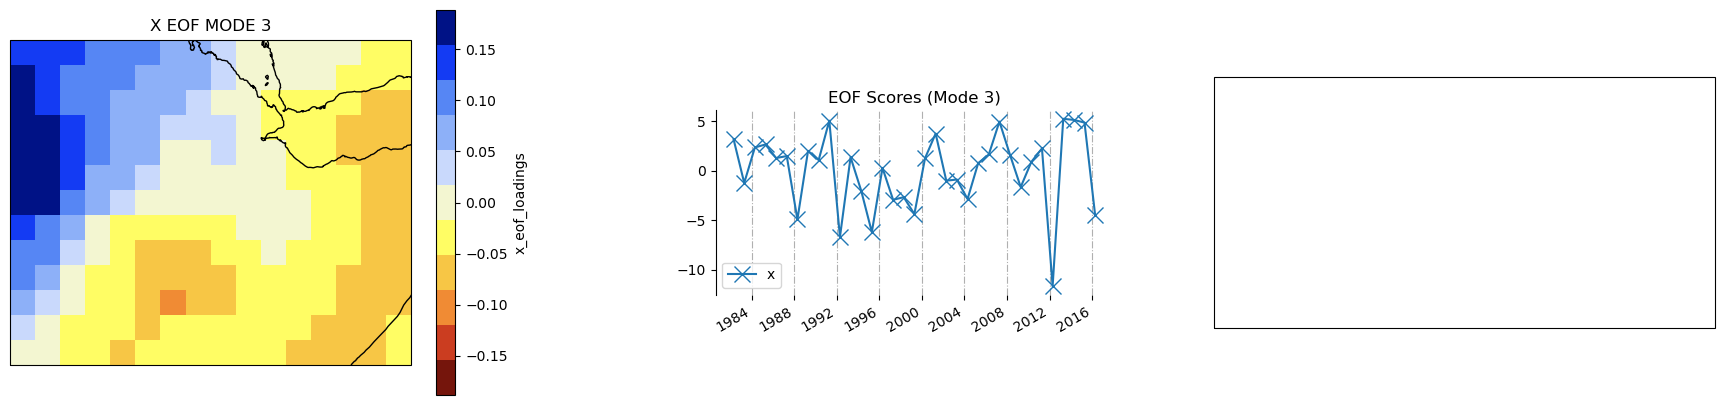

CCSM4.PRCP - MODE 1


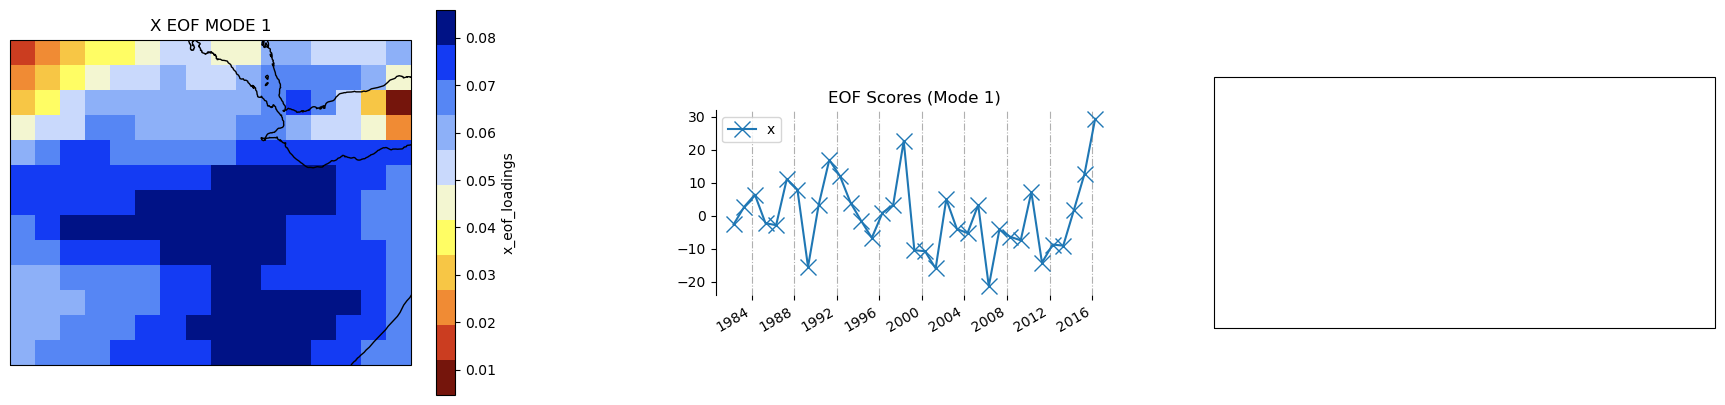

CCSM4.PRCP - MODE 2


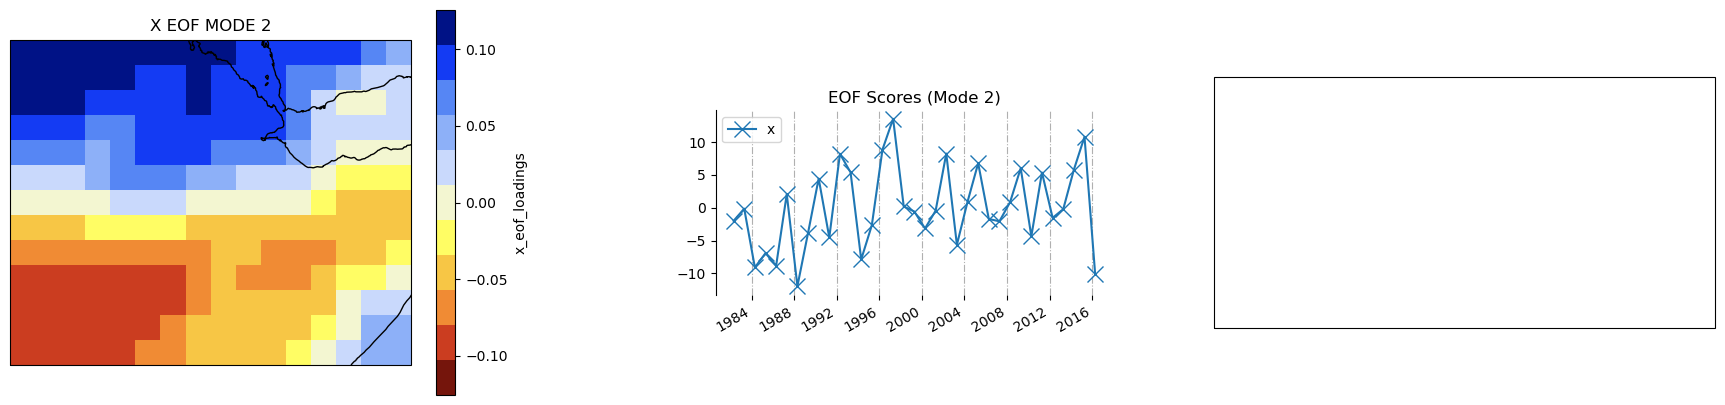

CCSM4.PRCP - MODE 3


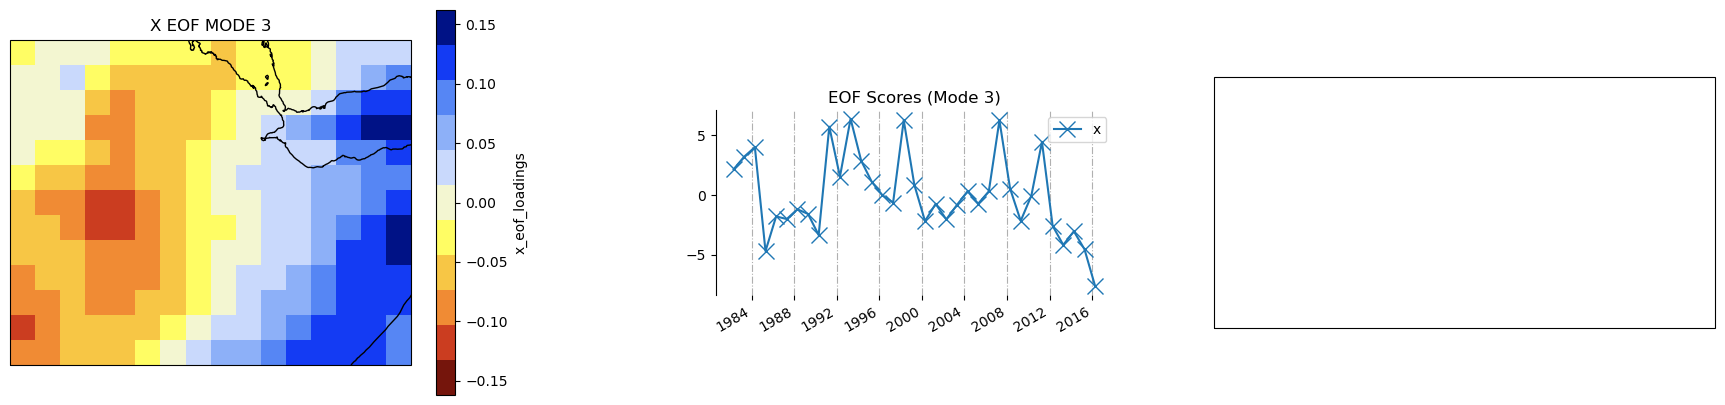

GEOSS2S.PRCP - MODE 1


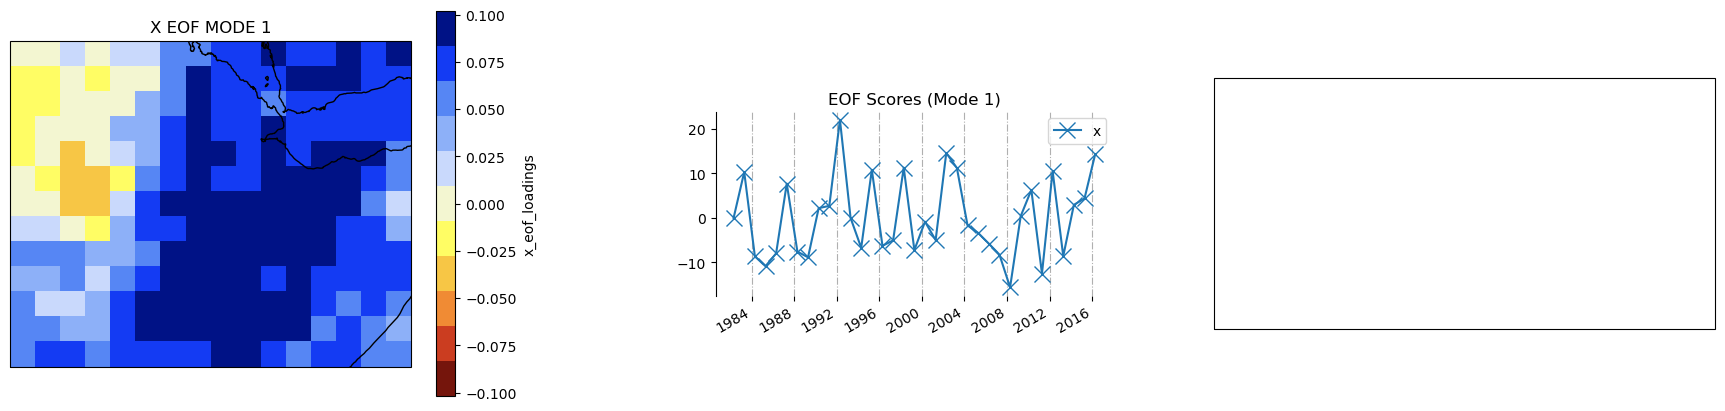

GEOSS2S.PRCP - MODE 2


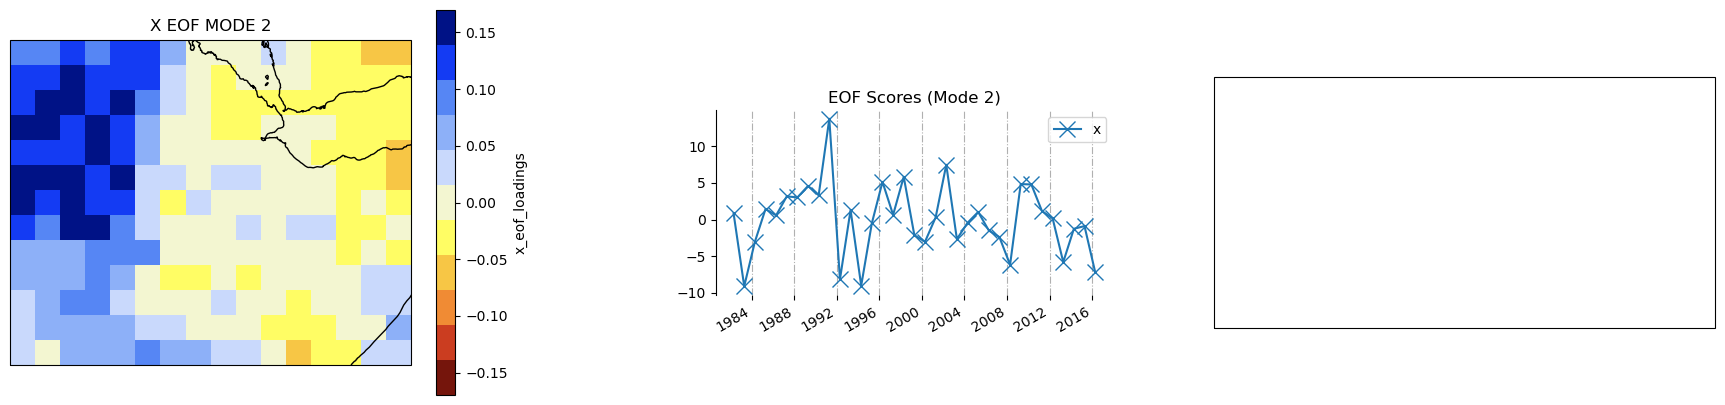

GEOSS2S.PRCP - MODE 3


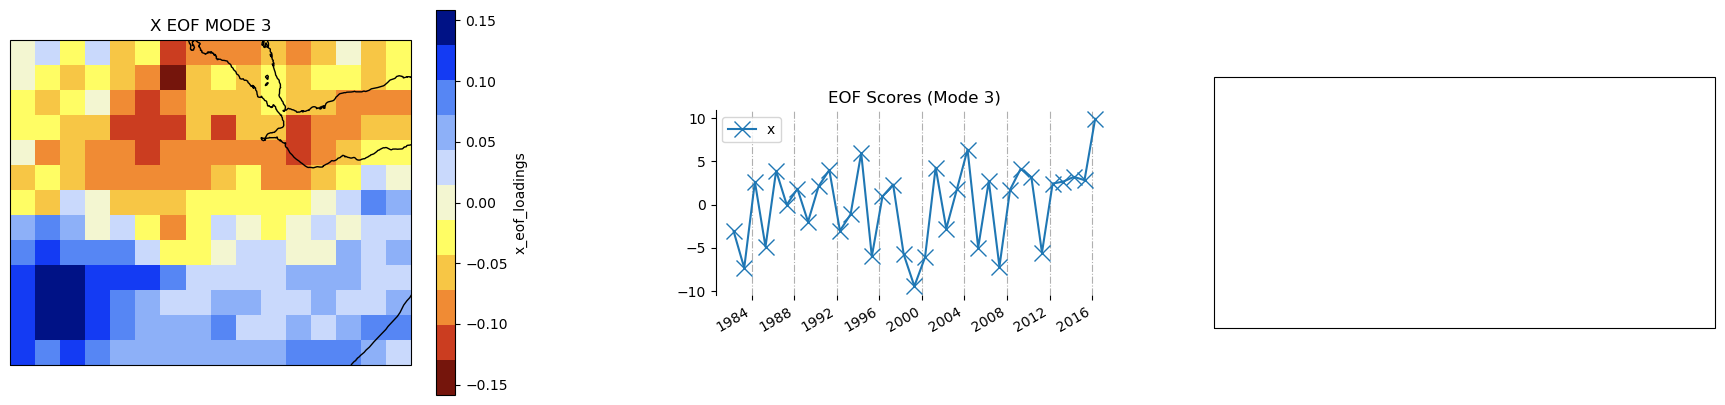

CFSV2.PRCP - MODE 1


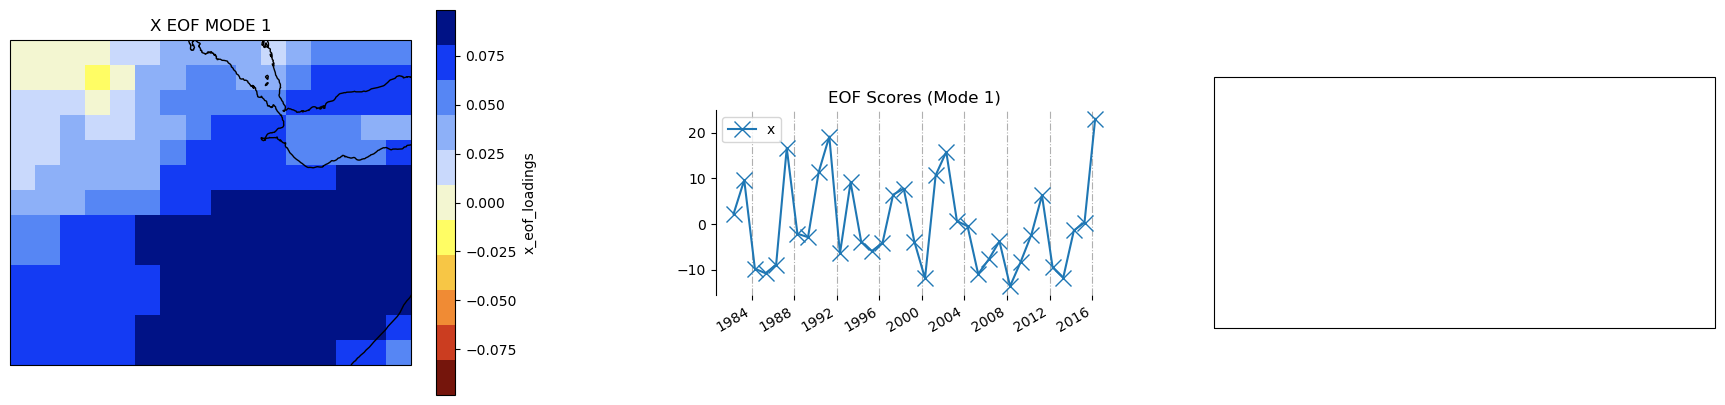

CFSV2.PRCP - MODE 2


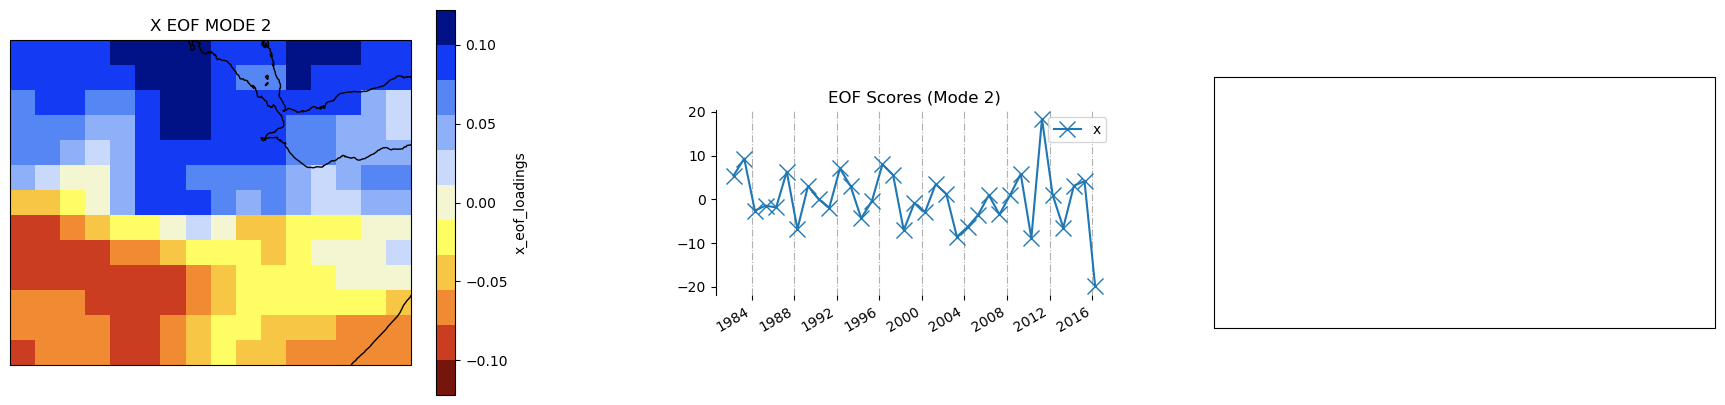

CFSV2.PRCP - MODE 3


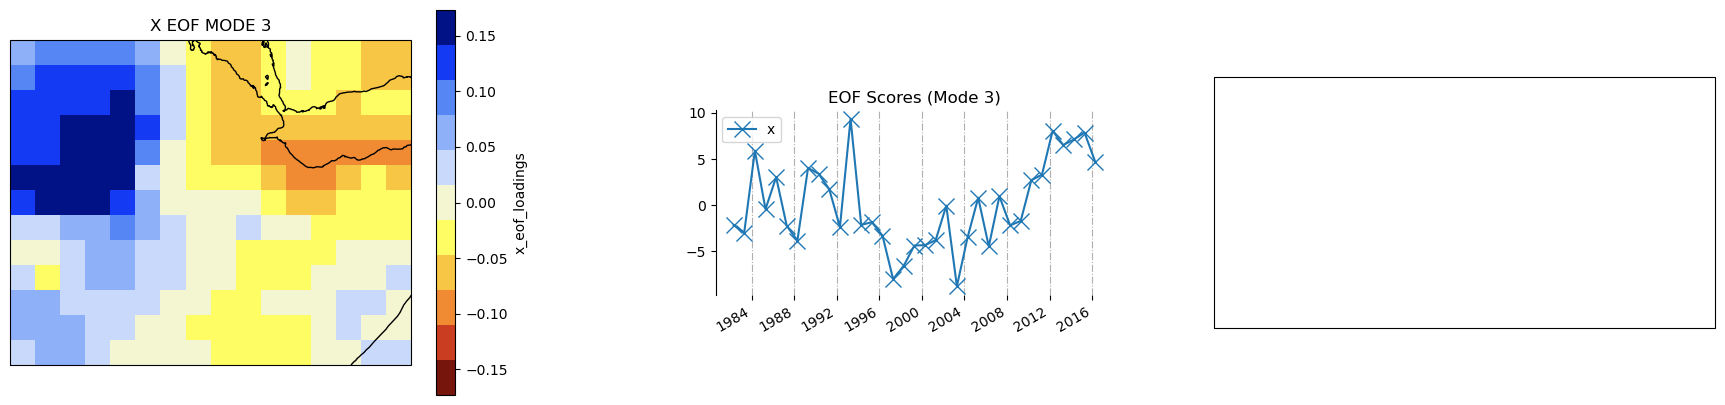

SEAS5.PRCP - MODE 1


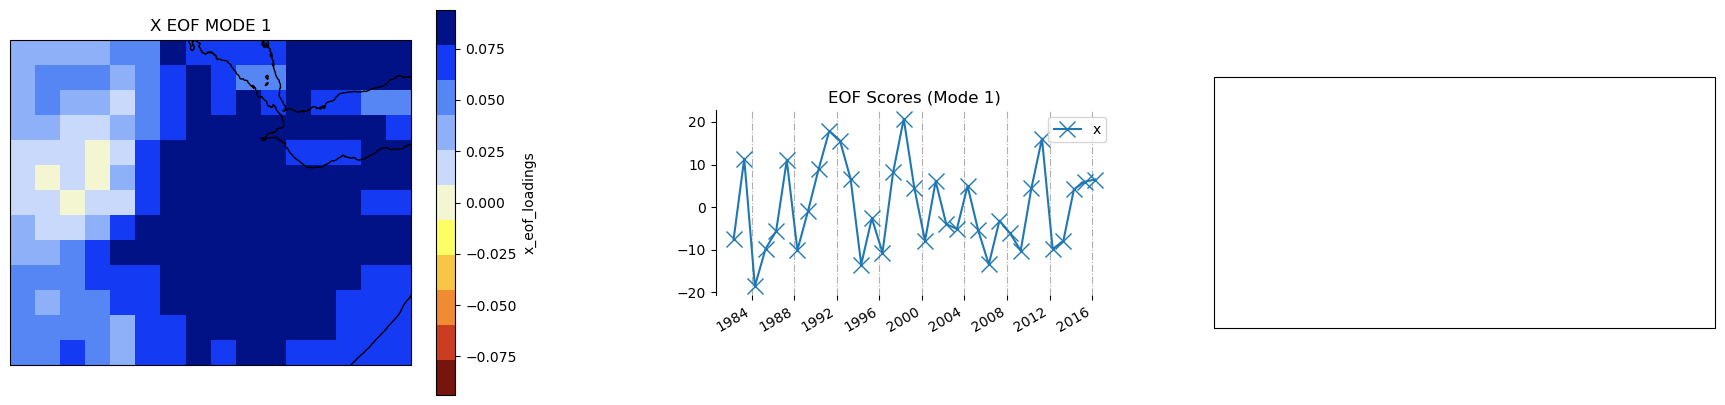

SEAS5.PRCP - MODE 2


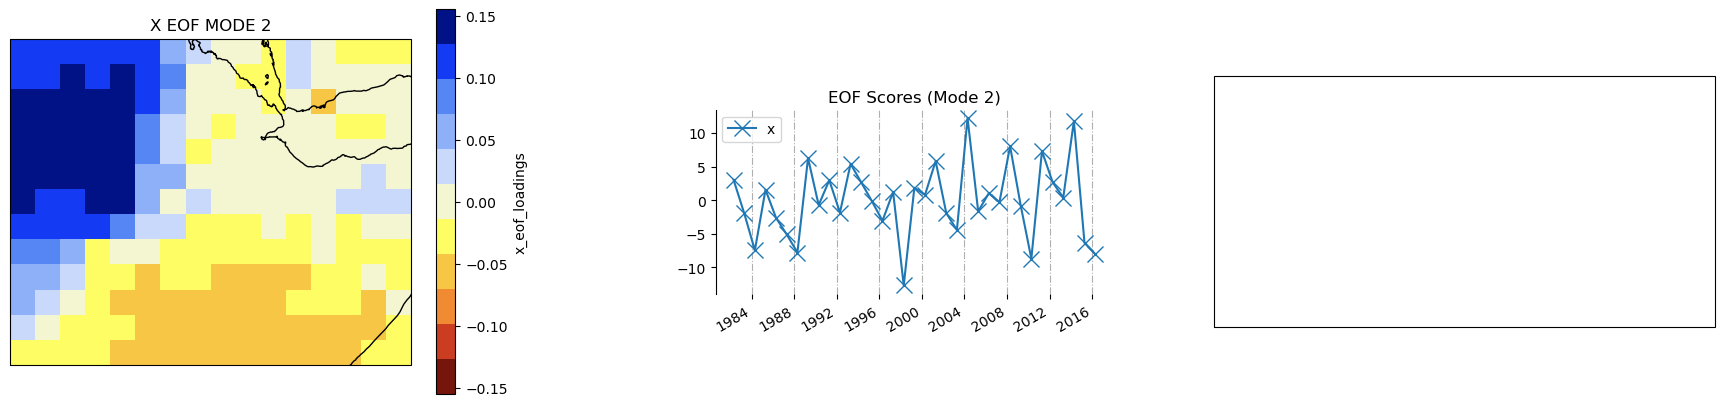

SEAS5.PRCP - MODE 3


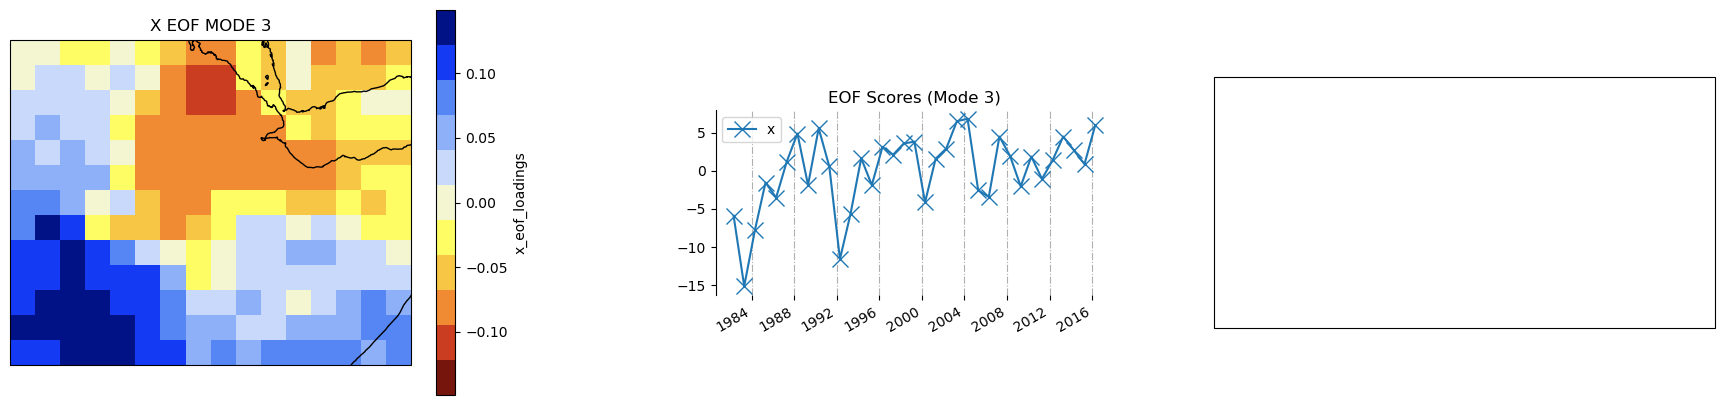

In [15]:
nmodes = 3
cmap= plt.get_cmap('cpt.loadings', 11)
vmin=-10
vmax = 10

import matplotlib.gridspec as gridspec
if MOS == 'CCA':
    for i, model in enumerate(predictor_names):
        for mode in range(nmodes):
            print(model.upper() + ' - MODE {}'.format(mode+1))
            fig = plt.figure(figsize=(20,5))
            gs0 = gridspec.GridSpec(1, 3, figure=fig)
            gs00 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[0])
            gs01 = gridspec.GridSpecFromSubplotSpec(4, 5, subplot_spec=gs0[1])
            gs02 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[2])
            ts = xr.concat([pxs[i].x_eof_scores.isel(Mode=mode), pys[i].y_eof_scores.isel(Mode=mode)], 'M').assign_coords({'M': ['x', 'y']})
            
            map1_ax = fig.add_subplot(gs00[:,:], projection = ccrs.PlateCarree())
            ts_ax = fig.add_subplot( gs01[1:3,1:])
            map2_ax = fig.add_subplot(gs02[:,:], projection = ccrs.PlateCarree())
            
            pxs[i].x_eof_loadings.isel(Mode=mode).where(pxs[i].x_eof_loadings.isel(Mode=mode) > missing_value_flag).plot(ax=map1_ax, cmap=cmap)
            pys[i].y_eof_loadings.isel(Mode=mode).where(pys[i].y_eof_loadings.isel(Mode=mode) > missing_value_flag).plot(ax=map2_ax, cmap=cmap)

            primitive = ts.plot.line(marker='x', ax=ts_ax, markersize=12, hue='M', add_legend=False)
            ts_ax.grid(axis = 'x', linestyle = '-.')
            ts_ax.legend(handles=primitive, labels = list(ts.coords['M'].values), loc='best')
            ts_ax.spines['top'].set_visible(False)
            ts_ax.spines['right'].set_visible(False)
            ts_ax.spines['bottom'].set_visible(False)
            ts_ax.set_title('EOF Scores (Mode {})'.format(mode+1))
            ts_ax.set_ylabel(None)
            ts_ax.set_xlabel(None)
            
            map1_ax.set_title('X EOF MODE {}'.format(mode+1))
            map2_ax.set_title('Y EOF MODE {}'.format(mode+1))
            
            map1_ax.coastlines()
            map2_ax.coastlines()
            
            map1_ax.add_feature(cartopyFeature.BORDERS)
            map2_ax.add_feature(cartopyFeature.BORDERS)
            
            
            figName = MOS +'_'+ str(model) +'_EOF_mode_' + str(mode + 1) + '.png'
            fig.savefig(Path.home() / "Desktop" / caseDir / domainFolder / "figures" / figName, bbox_inches='tight')

            plt.show()
elif MOS == 'PCR':
    for i, model in enumerate(predictor_names):
        for mode in range(nmodes):
            print(model.upper() + ' - MODE {}'.format(mode+1))
            fig = plt.figure(figsize=(22,5))
            gs0 = gridspec.GridSpec(1, 3, figure=fig)
            gs00 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[0])
            gs01 = gridspec.GridSpecFromSubplotSpec(4, 5, subplot_spec=gs0[1])
            gs02 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[2])
            ts = xr.concat([pxs[i].x_eof_scores.isel(Mode=mode)], 'M').assign_coords({'M': ['x']})
            
            map1_ax = fig.add_subplot(gs00[:,:], projection = ccrs.PlateCarree())
            ts_ax = fig.add_subplot( gs01[1:3,1:])
            map2_ax = fig.add_subplot(gs02[:,:], projection = ccrs.PlateCarree())
            
            pxs[i].x_eof_loadings.isel(Mode=mode).where(pxs[i].x_eof_loadings.isel(Mode=mode) > missing_value_flag).plot(ax=map1_ax, cmap=cmap)            #pys[i].y_eof_loadings.isel(Mode=mode).plot(ax=map2_ax, cmap=cmap)

            primitive = ts.plot.line(marker='x', ax=ts_ax, markersize=12, hue='M', add_legend=False)
            ts_ax.grid(axis = 'x', linestyle = '-.')
            ts_ax.legend(handles=primitive, labels = list(ts.coords['M'].values), loc='best')
            ts_ax.spines['top'].set_visible(False)
            ts_ax.spines['right'].set_visible(False)
            ts_ax.spines['bottom'].set_visible(False)
            ts_ax.set_title('EOF Scores (Mode {})'.format(mode+1))
            ts_ax.set_ylabel(None)
            ts_ax.set_xlabel(None)
            
            map1_ax.set_title('X EOF MODE {}'.format(mode+1))
            #map2_ax.set_title('Y EOF MODE {}'.format(mode+1))
            
            map1_ax.coastlines()
            #map2_ax.coastlines()

            figName = MOS +'_'+ str(model) +'_EOF_mode_' + str(mode + 1) + '.png'
            fig.savefig(Path.home() / "Desktop" / caseDir / domainFolder / "figures" / figName, bbox_inches='tight')

            plt.show()
else:
    print('You will need to set MOS=CCA in order to see CCA Modes')
        


#### Plot Forecasts

CANSIPSV2.PRCP


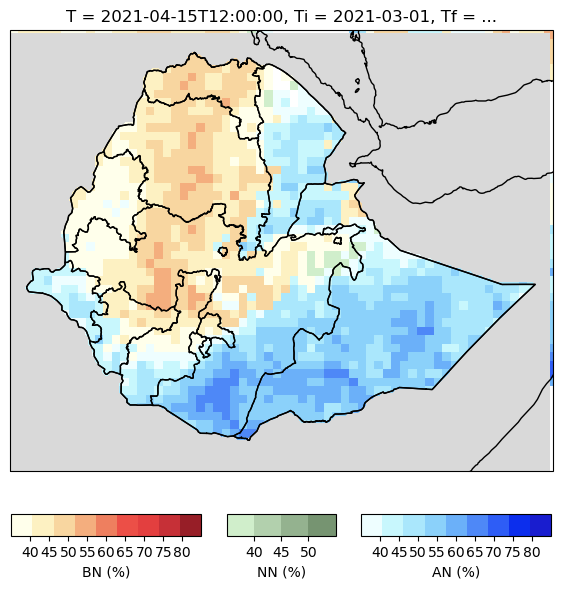

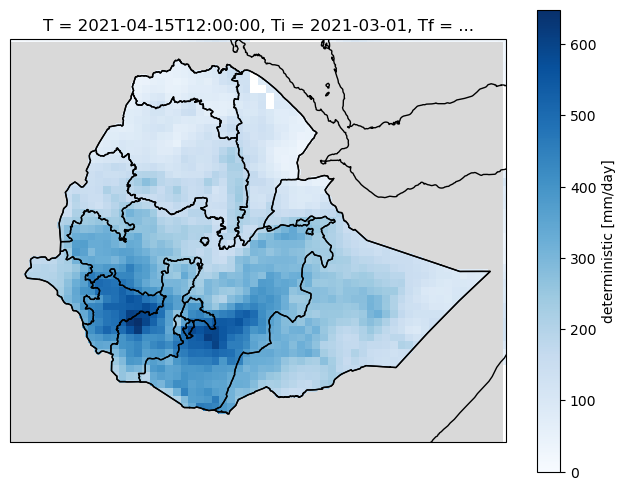

CCSM4.PRCP


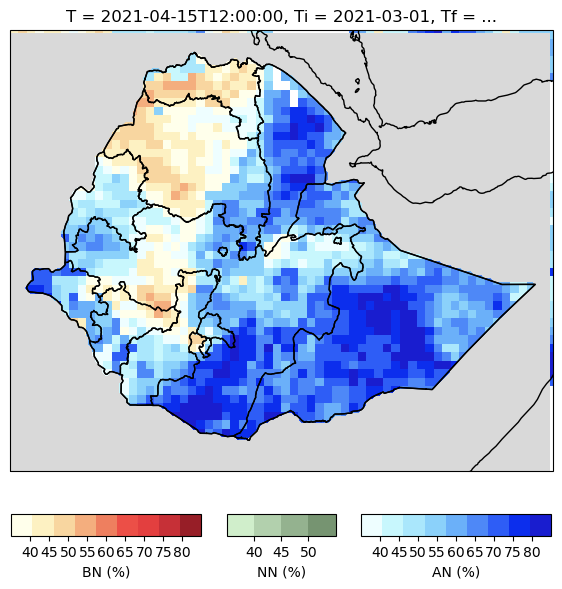

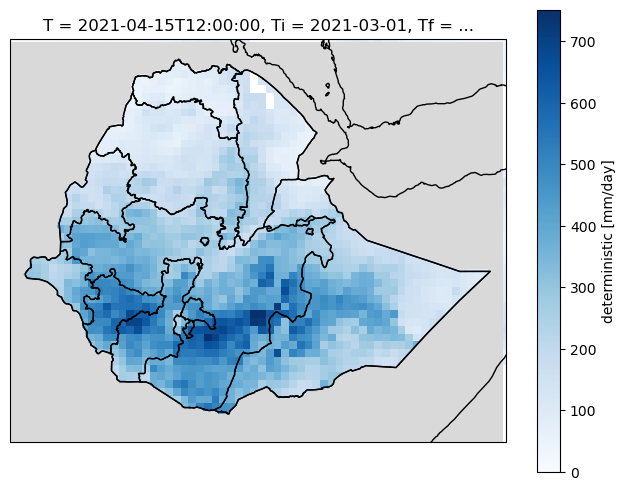

GEOSS2S.PRCP


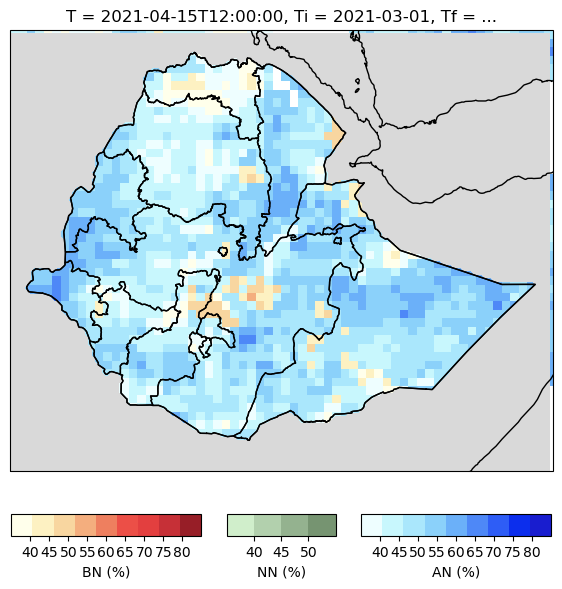

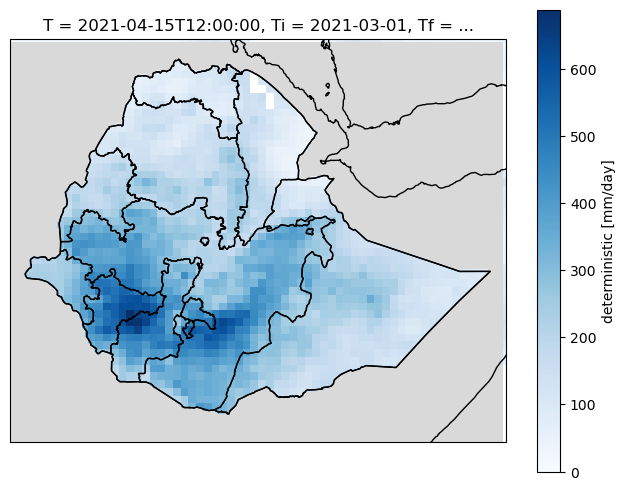

CFSV2.PRCP


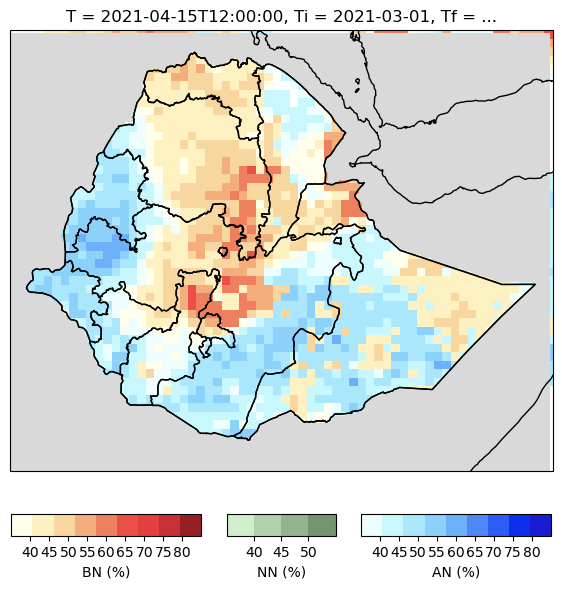

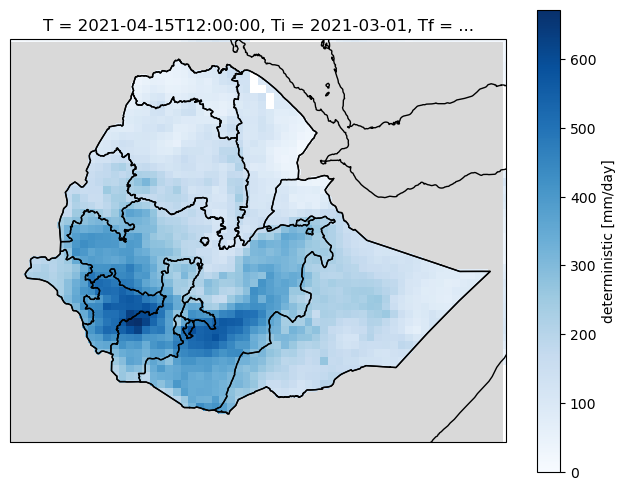

SEAS5.PRCP


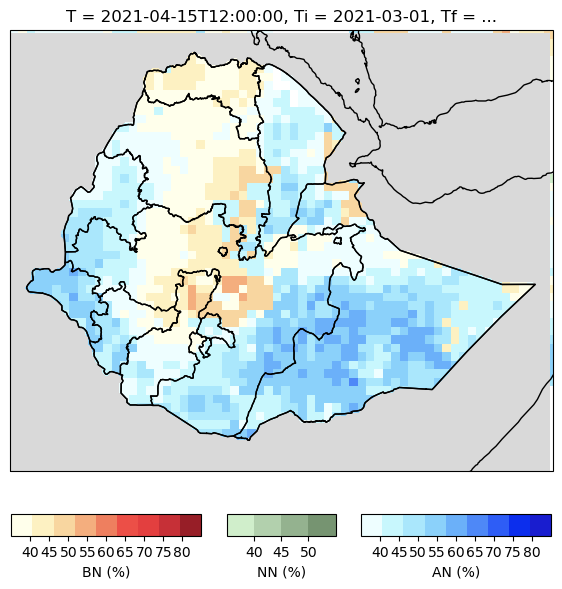

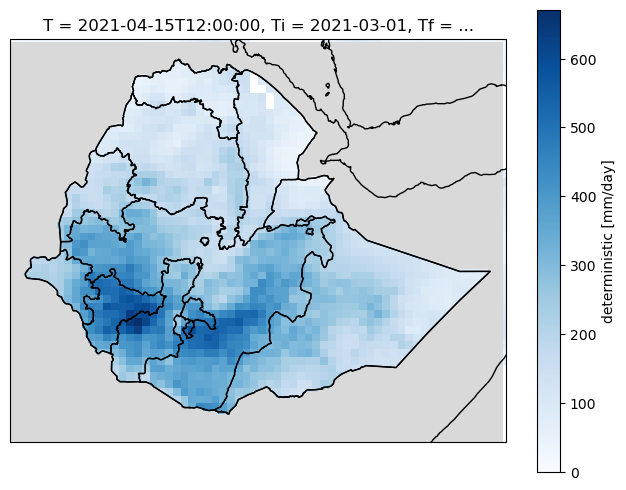

In [18]:
missing_value_flag = -999
prob_missing_value_flag = -1

for i in range(len(fcsts)):
    print(predictor_names[i].upper())
    
    figInstance, axisInstance =  ce.view_probabilistic(fcsts[i].probabilistic.where(fcsts[i].probabilistic > prob_missing_value_flag).rename({'C':'M'}).isel(T=-1) / 100)
    axisInstance.add_feature(countryShape)
    axisInstance.add_feature(regionShape)
    
    #apply the mask here
    axisInstance.contourf(lons,lats, np.where(mask,0,np.nan), cmap='Greys')
    
    figName = MOS +'_'+ predictor_names[i] + '_probabilisticForecast'+'.png'
    plt.savefig(Path.home() / "Desktop" / caseDir / domainFolder / "figures" / figName, bbox_inches='tight')

    plt.show()
    
    art = fcsts[i].deterministic.where(fcsts[i].deterministic > missing_value_flag).isel(T=-1).plot(figsize=(8,6), subplot_kws={'projection': ccrs.PlateCarree()}, cmap='Blues', vmin=0)
    art.axes.coastlines()
    
    art.axes.add_feature(countryShape)
    art.axes.add_feature(regionShape)
    
    #apply the mask here
    art.axes.contourf(lons,lats, np.where(mask,0,np.nan), cmap='Greys')
    
    figName = MOS +'_'+ predictor_names[i] + '_determinsticForecast'+'.png'
    plt.savefig(Path.home() / "Desktop" / caseDir / domainFolder / "figures" / figName, bbox_inches='tight')
    
    plt.show()

# Multi-Model Ensemble

In [19]:
#ensemble = ['SEAS5.PRCP','SPEAR.PRCP',  'CanSIPSIC3.PRCP' ]
#ensemble = ['CFSv2.PRCP','GEOSS2S.PRCP']
ensemble = ['CanSIPSv2.PRCP','GEOSS2S.PRCP','SEAS5.PRCP']


### Do not modify below

det_fcst = []
det_hcst = []
pr_fcst = []
pr_hcst = []
pev_fcst = []
pev_hcst = []
for model in ensemble:
    assert model in predictor_names, "all members of the nextgen ensemble must be in predictor_names - {} is not".format(model)
    ndx = predictor_names.index(model)
    
    det_fcst.append(fcsts[ndx].deterministic)
    det_hcst.append(hcsts[ndx].deterministic)
    pr_fcst.append(fcsts[ndx].probabilistic)
    pr_hcst.append(hcsts[ndx].probabilistic)
    pev_fcst.append(fcsts[ndx].prediction_error_variance)
    pev_hcst.append(hcsts[ndx].prediction_error_variance)

det_fcst = xr.concat(det_fcst, 'model').mean('model')
det_hcst = xr.concat(det_hcst, 'model').mean('model')
pr_fcst = xr.concat(pr_fcst, 'model').mean('model')
pr_hcst = xr.concat(pr_hcst, 'model').mean('model')
pev_fcst = xr.concat(pev_fcst, 'model').mean('model')
pev_hcst = xr.concat(pev_hcst, 'model').mean('model')

det_hcst.attrs['missing'] = hcsts[0].attrs['missing']
det_hcst.attrs['units'] = hcsts[0].attrs['units']

pr_hcst.attrs['missing'] = hcsts[0].attrs['missing']
pr_hcst.attrs['units'] = hcsts[0].attrs['units']


nextgen_skill_deterministic = cc.deterministic_skill(det_hcst, Y, **cpt_args)
nextgen_skill_probabilistic = cc.probabilistic_forecast_verification(pr_hcst, Y, **cpt_args)
nextgen_skill = xr.merge([nextgen_skill_deterministic, nextgen_skill_probabilistic])

#### NextGen Forecast Skill

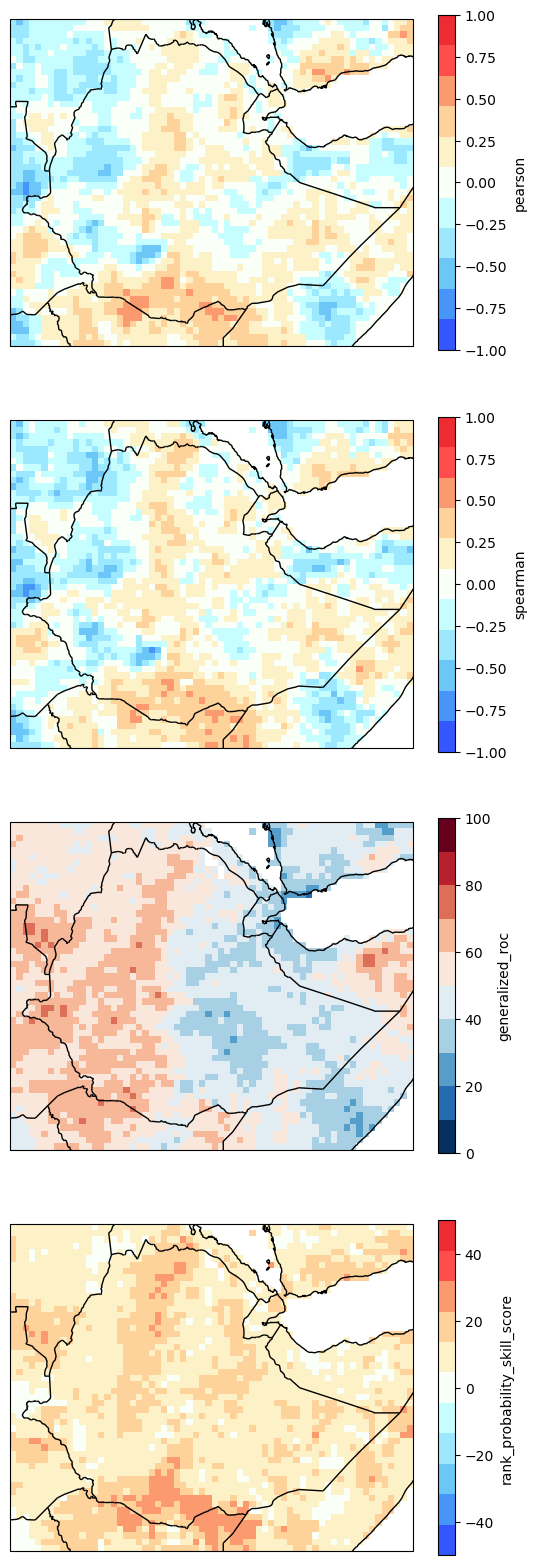

In [20]:
skill_metrics = ['pearson', 'spearman', 'generalized_roc', 'rank_probability_skill_score']
#cmaps = [plt.get_cmap('RdBu', 11), plt.get_cmap('RdBu', 11), plt.get_cmap('autumn_r', 10), plt.get_cmap('autumn_r', 11) ]
#limits = [(-1, 1), (-1, 1), (50, 100), (0, 50)]
cmaps = [plt.get_cmap('cpt.correlation', 11), plt.get_cmap('cpt.correlation', 11), plt.get_cmap('RdBu_r', 10), plt.get_cmap('cpt.correlation', 11) ]
limits = [(-1, 1), (-1, 1), (0, 100), (-50, 50)]
cmaps[2].set_under('lightgray')
cmaps[3].set_under('lightgray')


## Do not modify below
fig, ax = plt.subplots(nrows=len(skill_metrics), ncols=1, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(6.5, 5*len(skill_metrics)))
for j, skill_metric in enumerate(skill_metrics):
    ax[j].set_title(skill_metric)
    getattr(nextgen_skill, skill_metric).where(getattr(nextgen_skill, skill_metric) > missing_value_flag).plot(ax=ax[j], cmap=cmaps[j], vmin=limits[j][0], vmax=limits[j][1])
    ax[j].add_feature(cartopyFeature.BORDERS)
    ax[j].coastlines()
figName = MOS +'_ensemble_forecast_skillMatrices.png'
fig.savefig(Path.home() / "Desktop" / caseDir / domainFolder / "figures" / figName, bbox_inches='tight')


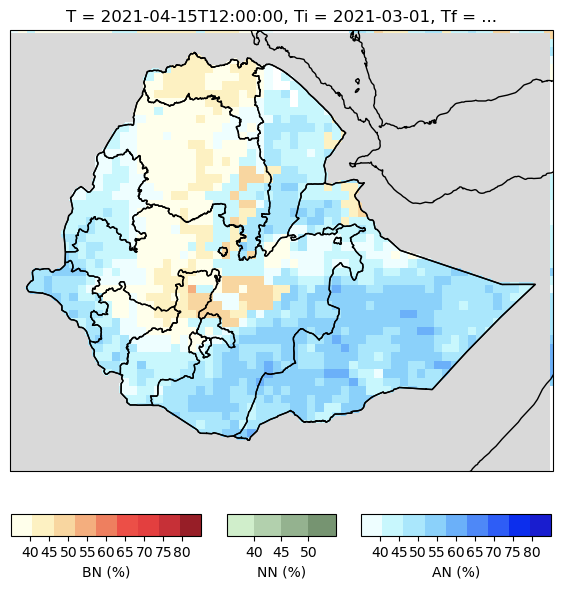

<class 'cartopy.mpl.geocollection.GeoQuadMesh'>


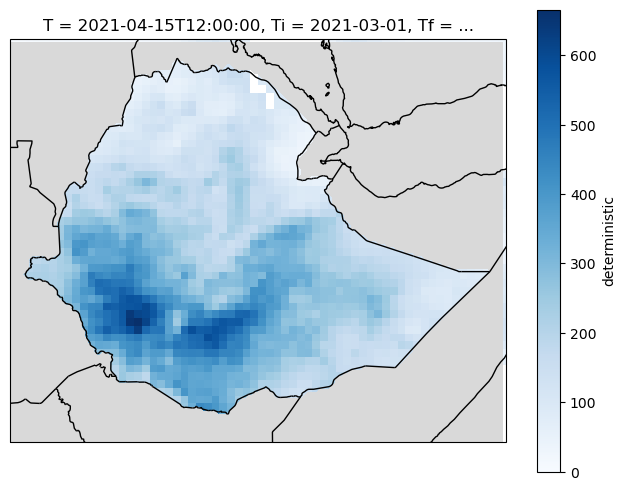

In [22]:
missing_value_flag = -999
prob_missing_value_flag = -1 

figInstance, axisInstance = ce.view_probabilistic(pr_fcst.where(pr_fcst > prob_missing_value_flag).rename({'C':'M'}).isel(T=-1) / 100)

axisInstance.add_feature(countryShape)
axisInstance.add_feature(regionShape)

#apply the mask here
axisInstance.contourf(lons,lats, np.where(mask,0,np.nan), cmap='Greys')

figName = MOS + '_ensemble_probabilisticForecast.png'
plt.savefig(Path.home() / "Desktop" / caseDir / domainFolder / "figures" / figName, bbox_inches='tight')

plt.show()
art = det_fcst.where(det_fcst > missing_value_flag).isel(T=-1).plot(figsize=(8,6),subplot_kws={'projection': ccrs.PlateCarree()}, cmap='Blues', vmin=0)
print(type(art))
art.axes.coastlines()
art.axes.add_feature(cartopyFeature.BORDERS)

#apply the mask here
art.axes.contourf(lons,lats, np.where(mask,0,np.nan), cmap='Greys')
#cb = fig.colorbar(ax=art)
#cb.set_label("deterministic (mm/month)")

figName = MOS + '_ensemble_deterministicForecast.png'
plt.savefig(Path.home() / "Desktop" / caseDir / domainFolder / "figures" / figName, bbox_inches='tight')

plt.show()

#### Flex Forecasts

In [23]:
threshold = 300 #if 'isPercentile' is True, the threshold is in percentiles else in the unit of the variable like mm/day, degC, ...
isPercentile = False
point_latitude = 5.03  #is a point in the predictand domain
point_longitude = 38.75

## DO not modify below

# Define transformer based on transform_predictand setting
if MOS =='CCA':
    if str(cpt_args['transform_predictand']).upper() == 'GAMMA':
        transformer = ce.GammaTransformer()
    elif str(cpt_args['transform_predictand']).upper() == 'EMPIRICAL':
        transformer = ce.EmpiricalTransformer()
    else:
        transformer = None
elif MOS == 'PCR':
    if str(cpt_args['transform_predictand']).upper() == 'GAMMA':
        transformer = ce.GammaTransformer()
    elif str(cpt_args['transform_predictand']).upper() == 'EMPIRICAL':
        transformer = ce.EmpiricalTransformer()
    else:
        transformer = None
else:
    print('FLEX FORECASTS NOT POSSIBLE WITHOUT MOS')

In [24]:
from scipy.stats import norm, t

# if the transformer is not none, then we used a y-transform in cpt
# therefore we have received a prediction error variance file in "units" of (standard normal deviates)^2
# and need to transform the forecast mean, in order to calculate probability of exceedance

if MOS in ['CCA', 'PCR']:
    if transformer is not None:
        # we need to normalize the forecast mean here, using the same method as CPT
        transformer.fit(Y.expand_dims({'M':[0]}))
        fcst_mu = transformer.transform(det_fcst.expand_dims({'M':[0]}))
    else:
        fcst_mu = det_fcst

    if isPercentile:
        if transformer is None:
            # if the user provided a percentile theshold, rather than an actual value
            # and also used no transformation / normalization, 
            # then we also need to compute the theshold as an actual value
            threshold = Y.quantile(threshold, dim='T').drop('quantile')
        else:
            # if the user used a transformation and gave a percentile threshold, 
            # we we can set the threshold using the cumulative distribution function 
            # for the normal distribution N(0, 1)- since thats what the Y data has 
            # been transformed to
            threshold = xr.ones_like(fcst_mu).where(~np.isnan(fcst_mu), other=np.nan) * norm.cdf(threshold)
    else:
        if transformer is None:
            # if the user did not use a transform, and also did not use a percentile for a threshold,
            # we can just use the value directly. but it must be expanded to a 2D datatype
            threshold = xr.ones_like(fcst_mu).where(~np.isnan(fcst_mu), other=np.nan) * threshold 
        else: 
            # if the user used a transformation, but gave a full value and NOT a percentile, 
            # we must use the transformation that CPT used to transform the threshold onto 
            # the normal distribution at N(0, 1)
            threshold = xr.ones_like(fcst_mu).where(~np.isnan(fcst_mu), other=np.nan) * threshold 
            threshold = transformer.transform(threshold)
    
    def _xr_tsf(thrs, loc1, scale1, dof1=1):
        return t.sf(thrs, dof1, loc=loc1, scale=scale1)
    
    ntrain = Y.shape[list(Y.dims).index('T')]
    fcst_scale = np.sqrt( (ntrain -2)/ntrain * pev_fcst )
    
    # if we transformed the forecast data, we should transform the actual Y data to match
    if transformer is not None:
        Y2 = transformer.transform(Y.expand_dims({'M':[0]})).fillna(Y.min('T')) * xr.ones_like(Y.mean('T')).where(~np.isnan(Y.mean('T')), other=np.nan)
        Y2_fill = xr.where(~np.isfinite(Y2), 0, Y2)
        Y2 = xr.where(np.isfinite(Y2), Y2, Y2_fill)
    else:
        Y2 = Y
    # here we calculate the climatological mean and variance
    climo_var =  Y2.var('T') # xr.ones_like(fcst_mu).where(~np.isnan(fcst_mu), other=np.nan) if transformer is not None else
    climo_mu =  Y2.mean('T') # xr.ones_like(fcst_mu).where(~np.isnan(fcst_mu), other=np.nan) if transformer is not None else
    climo_scale = np.sqrt( (ntrain -2)/ntrain * climo_var )
    
    # we calculate here, the probability of exceedance by taking 1 - t.cdf()
    # after having transformed the forecast mean to match the units of the 
    # prediction error variance, if necessary.
    exceedance_prob = xr.apply_ufunc( _xr_tsf, threshold, fcst_mu, fcst_scale, input_core_dims=[['X', 'Y'], ['X', 'Y'], ['X', 'Y']], output_core_dims=[['X', 'Y']],keep_attrs=True, kwargs={'dof1':ntrain})    

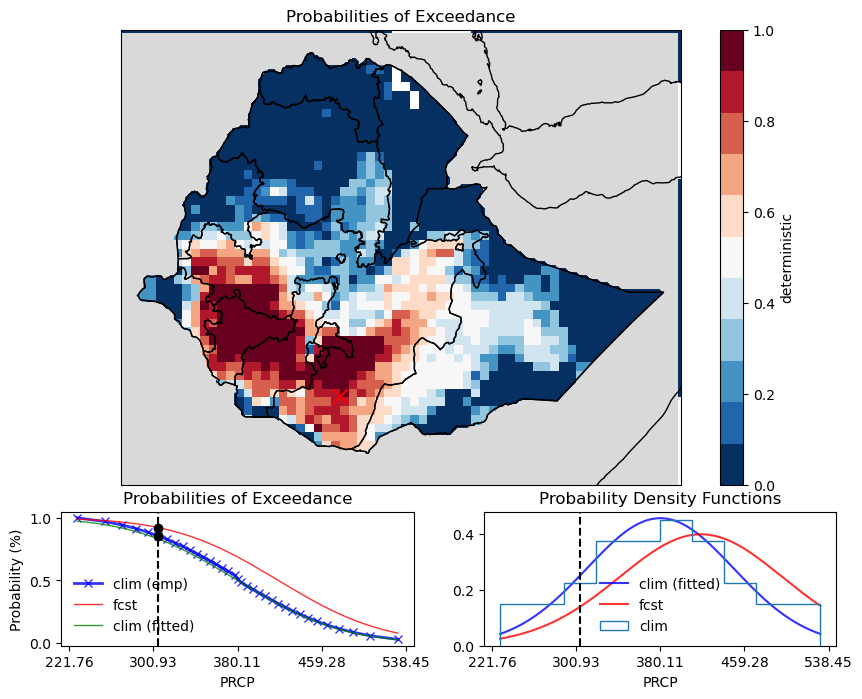

In [26]:
cmap=plt.get_cmap('RdBu_r', 11)


# setting up canvas on which to draw
fig = plt.figure(figsize=(10,8))
gs0 = gridspec.GridSpec(4, 1, figure=fig)
gs00 = gridspec.GridSpecFromSubplotSpec(5, 5, subplot_spec=gs0[:3])
gs11 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[3])
gs01 = gridspec.GridSpecFromSubplotSpec(5, 5, subplot_spec=gs11[0])
gs02 = gridspec.GridSpecFromSubplotSpec(5, 5, subplot_spec=gs11[1])

map_ax = fig.add_subplot(gs00[:,:], projection = ccrs.PlateCarree())
cdf_ax = fig.add_subplot(gs01[:,:])     
pdf_ax = fig.add_subplot(gs02[:,:])     

#plot the map
art = exceedance_prob.transpose('Y', 'X', ...).plot(cmap=cmap,  ax=map_ax, vmin=0, vmax=1) 
map_ax.scatter([point_longitude], [point_latitude], marker='x', s=100, color='red', transform=ccrs.PlateCarree())
coasts = art.axes.coastlines()

art.axes.add_feature(countryShape)
art.axes.add_feature(regionShape)

#apply the mask here
art.axes.contourf(lons,lats, np.where(mask,0,np.nan), cmap='Greys')

# point calculations - select the nearest point to the lat/lon the user wanted to plot curves
point_threshold = float(threshold.sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)
point_fcst_scale = float(fcst_scale.sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)
point_climo_scale = float(climo_scale.sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)
point_fcst_mu = float(fcst_mu.sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)
point_climo_mu = float(climo_mu.sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)
point_climo = np.squeeze(Y2.sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)
point_climo.sort()

if transformer is not None:
    point_climo_mu_nontransformed = float(Y.mean('T').sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)
    point_climo_std_nontransformed = float(Y.std('T').sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)


x = point_climo 
x1 =np.linspace(x.min(), x.max(), 1000)
cprobth =  sum(x >= point_threshold) / x.shape[0]  #round(t.sf(point_threshold, ntrain, loc=point_climo_mu, scale=point_climo_scale),2)
fprobth = round(t.sf(point_threshold, ntrain, loc=point_fcst_mu, scale=point_fcst_scale),2)



cdf_ax.plot(x, [ sum(x >= x[i]) / x.shape[0] for i in range(x.shape[0]) ],'b-', lw=2, marker='x', alpha=0.8, label='clim (emp)')
cdf_ax.plot(x1, t.sf(x1, ntrain, loc=point_fcst_mu, scale=point_fcst_scale),'r-',  lw=1, alpha=0.8, label='fcst')
cdf_ax.plot(x1, norm.sf(x1, loc=point_climo_mu, scale=point_fcst_scale),'g-', lw=1, alpha=0.8, label='clim (fitted)')


cdf_ax.plot(point_threshold, fprobth,'ok')
cdf_ax.plot(point_threshold, cprobth,'ok')
cdf_ax.axvline(x=point_threshold, color='k', linestyle='--')
cdf_ax.set_title('Probabilities of Exceedance')
cdf_ax.set_xlabel(Y.name.upper())
cdf_ax.set_ylabel('Probability (%)')
cdf_ax.legend(loc='best', frameon=False)

fpdf=t.pdf(x1, ntrain, loc=point_fcst_mu, scale=np.sqrt(point_fcst_scale))
pdf_ax.plot(x1, norm.pdf(x1, loc=point_climo_mu, scale =point_climo_scale), 'b-', alpha=0.8, label='clim (fitted)')
pdf_ax.plot(x1, fpdf, 'r-',  alpha=0.8, label='fcst')
pdf_ax.hist(point_climo, density=True, histtype='step', label='clim')

pdf_ax.axvline(x=point_threshold, color='k', linestyle='--')
pdf_ax.legend(loc='best', frameon=False)
pdf_ax.set_title('Probability Density Functions')
pdf_ax.set_xlabel(Y.name.upper())
pdf_ax.set_ylabel('')

if transformer is not None:
    newticks = [-2, -1, 0, 1, 2]
    pdf_ax.set_xticks(newticks, [round(i * point_climo_std_nontransformed + point_climo_mu_nontransformed, 2) for i in newticks], rotation=0)
    cdf_ax.set_xticks(newticks, [round(i * point_climo_std_nontransformed + point_climo_mu_nontransformed, 2) for i in newticks], rotation=0)

title = map_ax.set_title('Probabilities of Exceedance')

figName = MOS +'_flexForecast_probExceedence.png'
plt.savefig(Path.home() / "Desktop" / caseDir / domainFolder / "figures" / figName, bbox_inches='tight')